# Reddit Capstone after Labelling 
### Second natebook

The labelled and shrunken data will be loaded and used for EDA and cleaning.

The career categories I have identified are:
1. Fitness
2. Games
3. Politics
4. Science_Technology
5. Sports

In [1137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# to pickle models
import joblib

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Importing tokenizer
from redditscore.tokenizer import CrazyTokenizer

# importing countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Imporitng relevant models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [1042]:
# Loading the stored dataset for EDA and Modeling
data = pd.read_csv('text_df.csv', index_col=[0])
print(data.shape)
data.head(2)

(265290, 6)


subreddit                                  body    topic  count  \
0   science  More Olympics means heavier babies\n  science   6822   
1   science    china does seem to like their smog  science   6822   

    y_career_category  coded_category  
0  science_technology               3  
1  science_technology               3

#### Step-2: Creating a new dataframe that will have text data and labels as teh new working table.

In [1049]:
# creating a working directory with only required columns
text_df = data[['body', 'y_career_category', 'coded_category', 'count']].copy()
text_df.sample(5)

body   y_career_category  \
174321  A lot of things confuse me with this post, but...              sports   
179632  I saw Liverpool fans saying it was United fans...              sports   
210053  So we set up an arbitrary 36 min time limit to...              sports   
97441                                 How much is a porn?  science_technology   
202471  &gt; Promising a 3D game seems... ambitious.\n...               games   

        coded_category  count  
174321               4  51247  
179632               4  51247  
210053               4   8333  
97441                3  17699  
202471               1  15391

In [1050]:
# Looking for nulls in the dataframe
text_df[text_df.isna().any(axis=1)]

Empty DataFrame
Columns: [body, y_career_category, coded_category, count]
Index: []

In [1051]:
# checking if all nulls got deleted or not
text_df.isnull().sum()

body                 0
y_career_category    0
coded_category       0
count                0
dtype: int64

In [1048]:
text_df.shape

(265290, 4)

#### Step-1 Cleaning data

1. Lower case all text
2. Remove punctuations
3. Remove numbers and all words with numbers
4. tokenize

In [10]:
# FIRST ATTEMPT AT DATA CLEANING

# # Trying to split text on white spaces
# tokens = []
# for document in text:
#     tokens.append(document.split(' '))

# FreqDist(text.body).most_common(20)    

I can see some sentances rather than words. I will investigate it further in the follwoing cells.

In [11]:
# calling on hapaxes to see the least appearing words in text.
# FreqDist(body).hapaxes()

It is clear that the words are not being split. I will try to use more options to clean the text up and find means of tokenizing

In [1052]:
text_df['body'][10]

'**Ah, here we go:**  \n\n&gt; "The enzyme developed at UBC is seen as the first step in finding an economically viable way of overcoming that obstacle.\n&gt; \n&gt; “The big step here is that we’ve found a way to make these enzymes more powerful and potent,” said Kwan.\n&gt; \n&gt; Hypothetically, Kwan said the enzyme may one day be used in a clinical setting to quickly convert blood for patients in need.\n&gt; \n&gt; But he stressed that future is still some ways off.\n&gt; \n&gt; Kwan is the lead author of the study outlining the team’s success, which was recently published in the Journal of the American Chemical Society.\n&gt; \n&gt; The team included UBC associate professor Jayachandran Kizhakkedathu and staff at the Centre for Blood Research."\n&gt; \n&gt; \n\nFrom: http://metronews.ca/news/vancouver/1355079/ubc-creates-enzyme-that-could-change-blood-types/ \n\nSeems like it\'s not yet economically viable, and still not perfect.'

In [1054]:
import string # Importing the library string that will help in removing punctuations 
import re # Importing regex library
from nltk.corpus import stopwords

# FIRST PHASE OF CLEANING

# 1. Making all words lower case
text_df['body'] = text_df['body'].str.lower()

# 2. Removing websites - anthing starting with http and www
text_df['body'] = text_df['body'].str.replace(r'http\S+', '', regex=True).str.replace(r'www\S+', '', regex=True)

# 3. Removing punctuations
# Here I am replacing fullstop with space and removing punctutaions
text_df['body'] = text_df['body'].str.translate(str.maketrans('.' , ' ' , string.punctuation))

# 4. Remove numbers and all words with numbers
text_df['body'] = text_df['body'].str.replace('\d+', '') 


In [1056]:
text_df['body'][10]

'ah here we go  \n\ngt the enzyme developed at ubc is seen as the first step in finding an economically viable way of overcoming that obstacle\ngt \ngt “the big step here is that we’ve found a way to make these enzymes more powerful and potent” said kwan\ngt \ngt hypothetically kwan said the enzyme may one day be used in a clinical setting to quickly convert blood for patients in need\ngt \ngt but he stressed that future is still some ways off\ngt \ngt kwan is the lead author of the study outlining the team’s success which was recently published in the journal of the american chemical society\ngt \ngt the team included ubc associate professor jayachandran kizhakkedathu and staff at the centre for blood research\ngt \ngt \n\nfrom  \n\nseems like its not yet economically viable and still not perfect'

All words have become lowercase, websites have been removed, numbers have been removed and most punctuations have been removed. However, I still see inverted commas and some apsotophies and '/n'. In the second phase of cleaning below, I will be removing those below

In [1068]:
# SECOND PHASE OF CLEANING

# Removing \n 
text_df['body'] = text_df['body'].str.replace('\n', '')

In [1069]:
text_df['body'][10]

'ah here we go  gt the enzyme developed at ubc is seen as the first step in finding an economically viable way of overcoming that obstaclegt gt “the big step here is that we’ve found a way to make these enzymes more powerful and potent” said kwangt gt hypothetically kwan said the enzyme may one day be used in a clinical setting to quickly convert blood for patients in needgt gt but he stressed that future is still some ways offgt gt kwan is the lead author of the study outlining the team’s success which was recently published in the journal of the american chemical societygt gt the team included ubc associate professor jayachandran kizhakkedathu and staff at the centre for blood researchgt gt from  seems like its not yet economically viable and still not perfect'

---

'\n' has been removed, so I feel the basic cleaning has been completed. We have removed punctuations, \n, websites and all numbers. Let see if more things come along the way to clean up. 


Lets look at the class contribution below:

In [1073]:
# Now lets look at the classes and thier relative contribution to assess the calss balance
class_contribution = np.array(np.unique(text_df['coded_category'], return_counts=True))
print(np.sum(class_contribution[1]))
print(class_contribution[1])

265290
[34128 56018 50276 55726 69142]


In [1077]:
print(f'Class Proportins are: {class_contribution[1]/(np.sum(class_contribution[1]))}')

Class Proportins are: [0.12864413 0.2111576  0.18951336 0.21005692 0.26062799]


---
Fitness : 0.12
Games : 0.21
Politics: 0.19
ScienceTechnology : 21.0
Sports :0.26

The difference between soprts and fitness is alot and might lead to some porblems ahead. However, these were the maximum rows for fitness i could manage. If I have to get more rows for fitness, i might need to move the project to cloud.
The classes can be seen below.

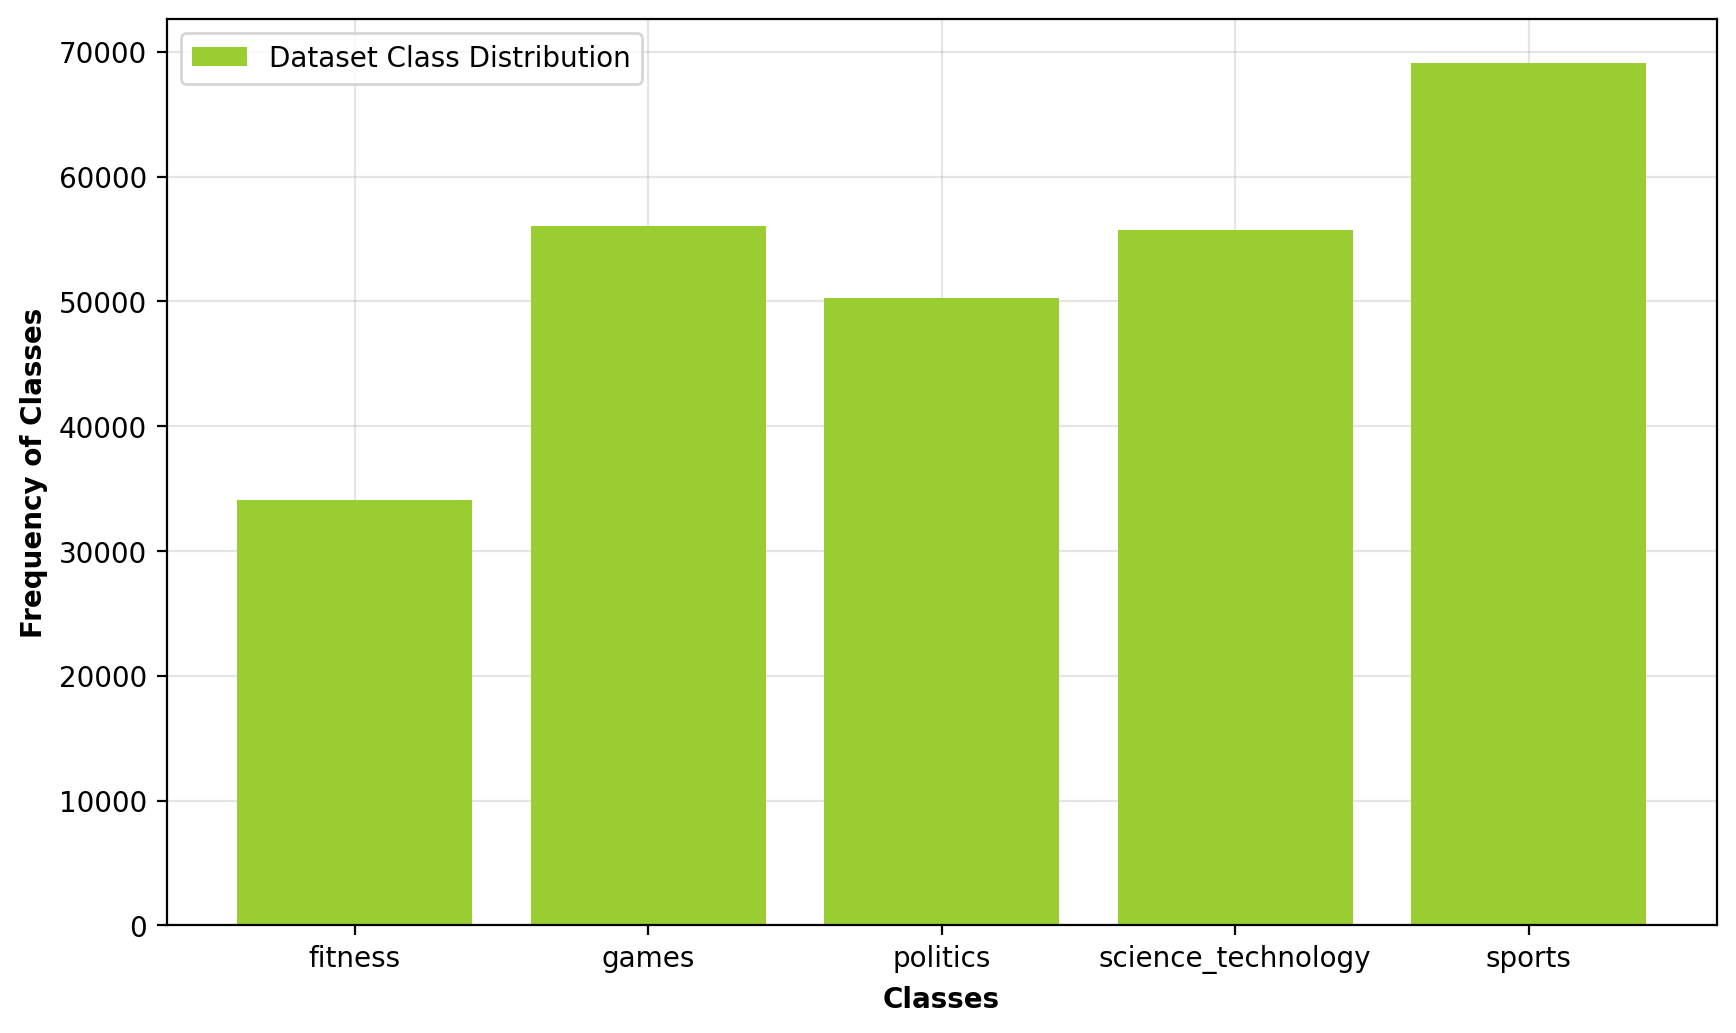

In [1074]:
# Visualizing the class Balance
plt.figure(figsize=(10, 6), dpi=200)
plt.bar(['fitness', 'games', 'politics', 'science_technology', 'sports'], 
        class_contribution[1], label='Dataset Class Distribution', color='yellowgreen', zorder=2)
plt.legend()
plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Frequency of Classes', fontweight='bold')
plt.grid(b=True, color='grey', alpha=0.2, zorder=0)
plt.show()

---

#### Step 2: Exploratory Data Analysis (EDA)

This was the first pass of cleaning for now. The next step is to divide the data into **train and test datasets.** Followed by **EDA.**


Creating a document term matrix to Perform EDA. This will help me visualize the data; 

- find the max and min frequency words
- make a word cloud
- see which words have the higest coefficients
- remove non-represenattive words from the dataset
- remove stop words


**WordClouds**

In order to visualize the classes better and identify what major words comprise it, I will make word clouds for all of them below.

In [1100]:
# Instantiating the tokenizer.
# This will ignore stopwords, use n-grams=2, remove emojis, subreddit names, urls, emails, lemmitize and decontract common words
crazy_tokenizer = CrazyTokenizer(ignore_stopwords=True, numbers='', subreddits='', emails='', urls='', decontract=True, ngrams=2,  
                                 pos_emojis='', neg_emojis='', neutral_emojis='', stem='lemm')

In [1124]:
# Generating a function to filter the rows on career code and generate word clouds for all the career buckets

def gen_wordclouds():
    i = 0 # iterator
    career_list = ['f', 'g', 'p', 'st', 'sp'] # variable list to save the concatinated string for each career bucket
    title = ['fitness', 'games', 'politics', 'science_technology', 'sports'] # list to give titles to career word clouds

    for n in career_list:  
        career_list[i] = text_df.body[text_df['coded_category'] == i].str.cat(sep= ' ') # extarcting each bucket on its code and 
        # concatinanting it together to give a single text string 
        print(f'{title[i]}: Concat Completed')

        tokens = crazy_tokenizer.tokenize(career_list[i][:1000000]) # tokenizing data for each career bucket, slicing to use 1 million letters
        wordss = ', '.join(tokens) # joinging the words to form a one cohesive word text 

        wordcloud = WordCloud(max_font_size=50, background_color='white', colormap='Dark2').generate(wordss) # generating world cloud

        # plotting word cloud
        plt.figure(figsize=(6,6), dpi=150)
        plt.title(title[i], fontweight='bold')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        i+=1

fitness: Concatinatin Completed


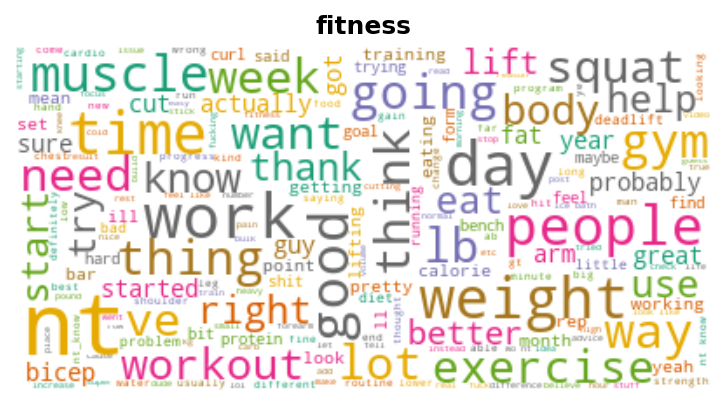

games: Concatinatin Completed


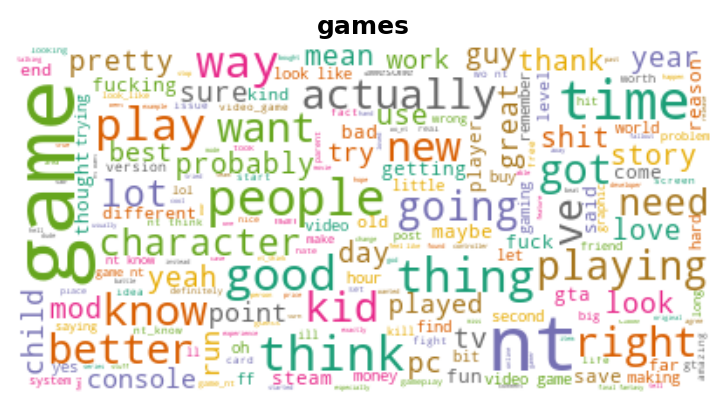

politics: Concatinatin Completed


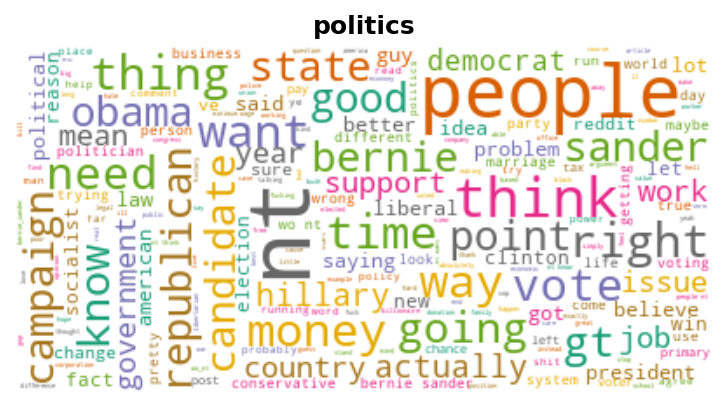

science_technology: Concatinatin Completed


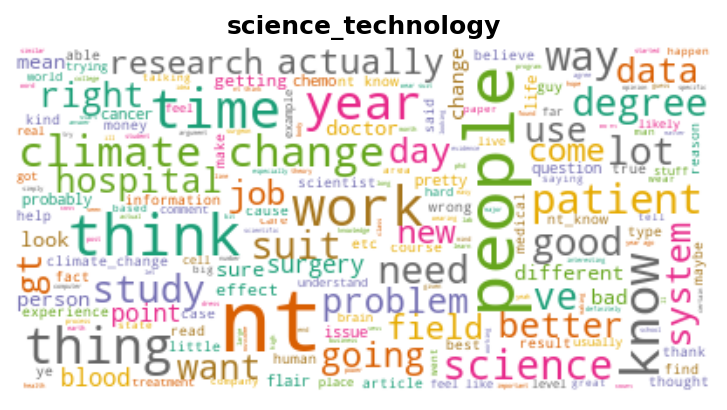

sports: Concatinatin Completed


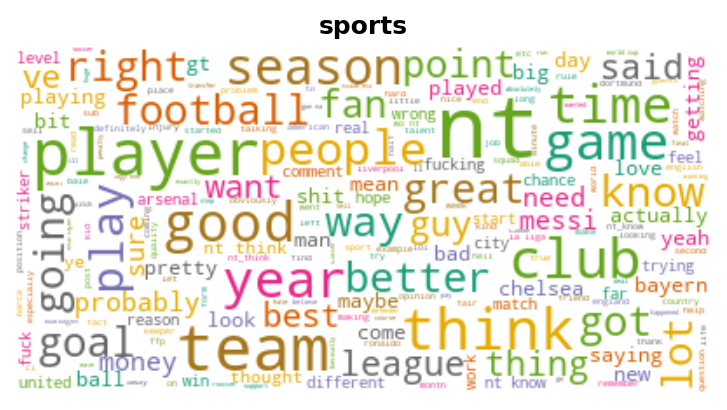

In [1125]:
gen_wordclouds()

All word clouds have 'nt' in them. It is a word reddit uses to identify language code.
I will remove this word and 'people' and 'good' from my dataset.

Note: stop words have already been removed. 

In [1126]:
# Removing nt, people and good
text_df['body'] = text_df['body'].str.replace('nt', '')
text_df['body'] = text_df['body'].str.replace('people', '')
text_df['body'] = text_df['body'].str.replace('good', '')

fitness: Concatinatin Completed


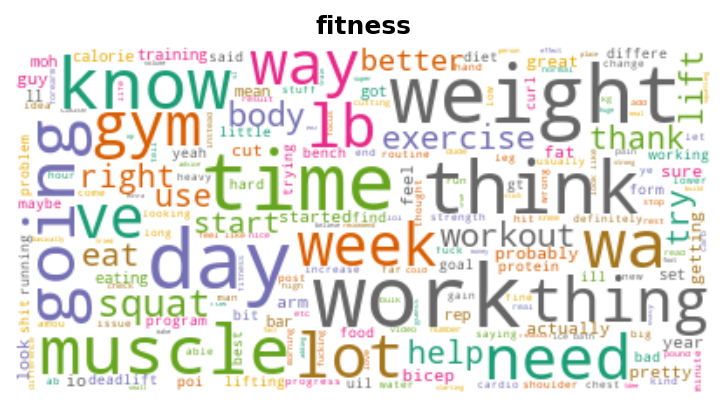

games: Concatinatin Completed


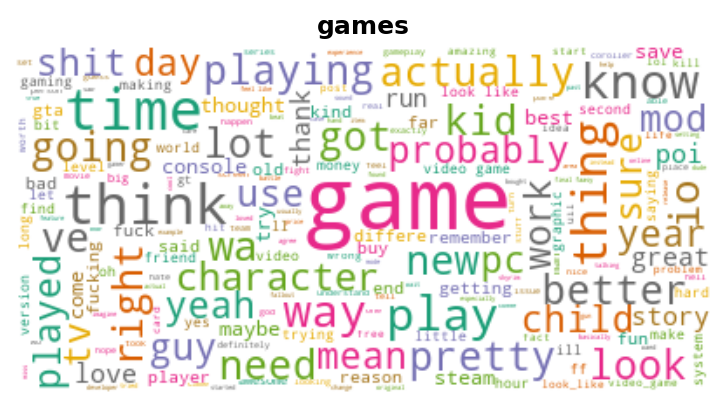

politics: Concatinatin Completed


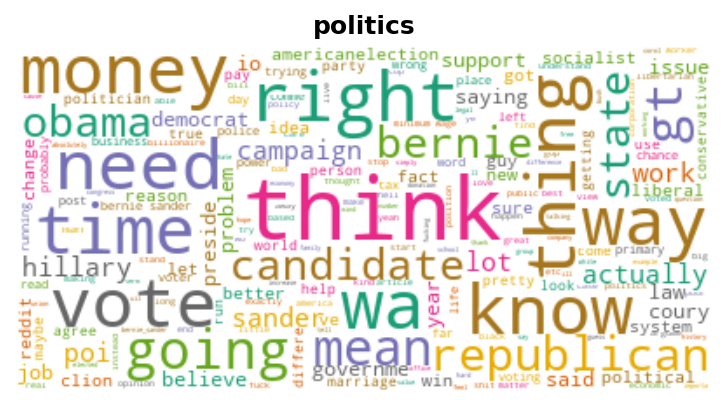

science_technology: Concatinatin Completed


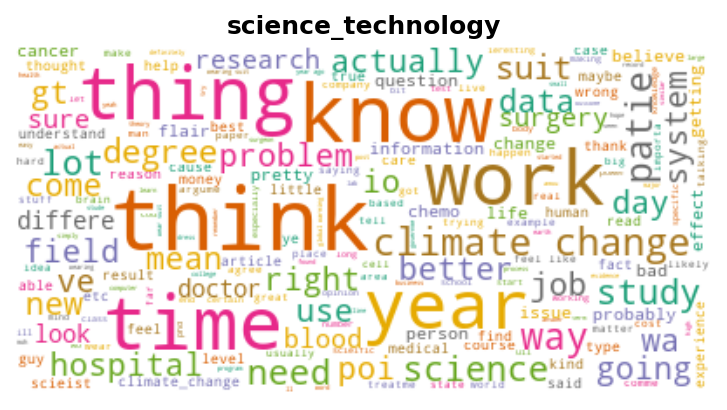

sports: Concatinatin Completed


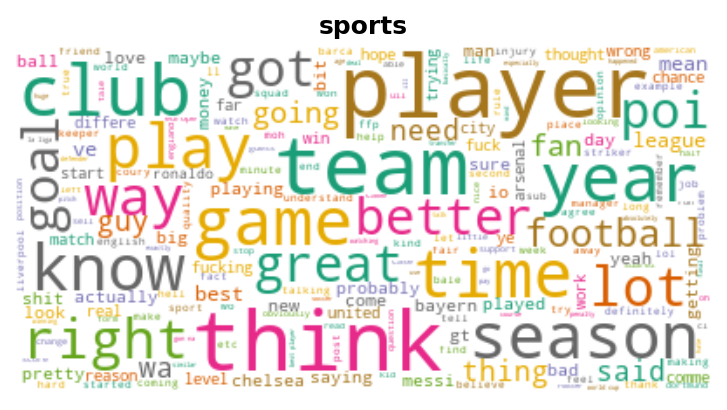

In [1127]:
gen_wordclouds()

#### Step 3: Modeling



**Train Test Split**

In [1271]:
from sklearn.model_selection import train_test_split

# Dividing the data farem into X and y 
X = text_df['body']
y = text_df['coded_category']

In [1272]:
# Dividing the data into testing and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1312, stratify=y)
print(f'X_train shape: {X_train.shape}')
print(f'X_train shape: {X_test.shape}')

X_train shape: (185703,)
X_train shape: (79587,)


In [1273]:
# Getting the count of each category

a = np.array(np.unique(y_train, return_counts=True))
b = np.array(np.unique(y_test, return_counts=True))
b[1]

array([10238, 16805, 15083, 16718, 20743], dtype=int64)

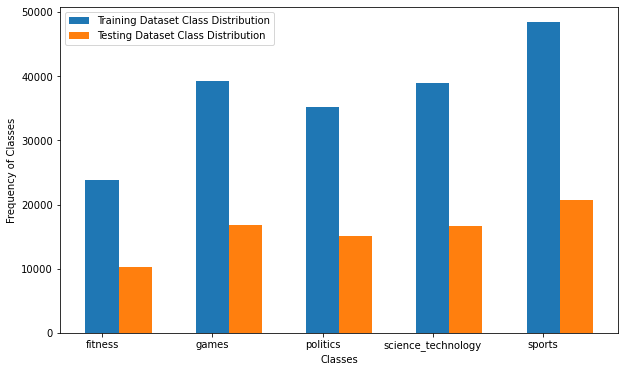

In [1274]:
# Plotting to see calss distribution in training and testing datasets

title = ['fitness', 'games', 'politics', 'science_technology', 'sports']

plt.figure(figsize=(10, 6))
width=0.3
plt.bar(title, a[1], width, label='Training Dataset Class Distribution')
plt.bar(b[0]+width, b[1], width, label='Testing Dataset Class Distribution')
plt.legend()
plt.xlabel('Classes')
plt.ylabel('Frequency of Classes')
plt.show()

The classes show relative balance, Fitness is low in number but the rest seem to have good relative frequency. 

**Vectorizing**

At first i will run a preliminary baseline vectorization and model without using the crazy tokenizer

##### Vectorizing text data into tokens

I will use two **vectorization techniques:**

1. Bag of words
2. TFIDF



**Bag of Words**

In [1275]:
# The tokenizer was instantiated earlier, for the sake of completeness, I am re-instaiting the exact model here. 

# Instantiating the tokenizer.
# This will ignore stopwords, use n-grams=2, remove emojis, subreddit names, urls, emails, lemmitize and decontract common words
crazy_tokenizer = CrazyTokenizer(ignore_stopwords=True, numbers='', subreddits='', emails='', urls='', decontract=True, ngrams=2,  
                                 pos_emojis='', neg_emojis='', neutral_emojis='', stem='lemm')

In [1276]:
# Running count vectorizer 
bagofwords = CountVectorizer(tokenizer=crazy_tokenizer.tokenize, min_df=5).fit(X_train)

X_train = bagofwords.transform(X_train)
X_test = bagofwords.transform(X_test)

In [1277]:
print(f'X_train shape after vectorizing: {X_train.shape}')

X_train shape after vectorizing: (185703, 74698)


In [1278]:
word_count = np.array(np.sum(X_train, axis=0))[0]
(word_count == 1).sum()

0

In [1279]:
# Pickiling the bagofwords model fro safety
joblib.dump(bagofwords, "bagofwords.pkl")

['bagofwords.pkl']

In [1287]:
# Cheching the shape of X_train. It is a sparce matrix with 185714 rows and 114576 columns
X_train

<185703x74698 sparse matrix of type '<class 'numpy.int64'>'
	with 2939652 stored elements in Compressed Sparse Row format>

In [1290]:
# Creating a data frame to find out the words with max frequency.
word_count = np.array(np.sum(X_train, axis=0))[0] # Getting the word count
words = np.array(bagofwords.get_feature_names()) # Getting teh feature names

words_df=pd.DataFrame({'words':words, 'count': word_count}) # Finally creating the df

In [1300]:
words.shape

(74698,)

In [1282]:
# sorting the df to give values from hughest to lowest.
words_df = words_df.sort_values(by='count', ascending=False)
words_df.head(10)

words  count
34254   like  27554
54543      s  27181
22168   game  20897
37382      m  19078
64488  think  16675
65477   time  14412
32342   know  11816
64096  thing  11158
69080     ve  10301
73952   year   9931

<BarContainer object of 20 artists>

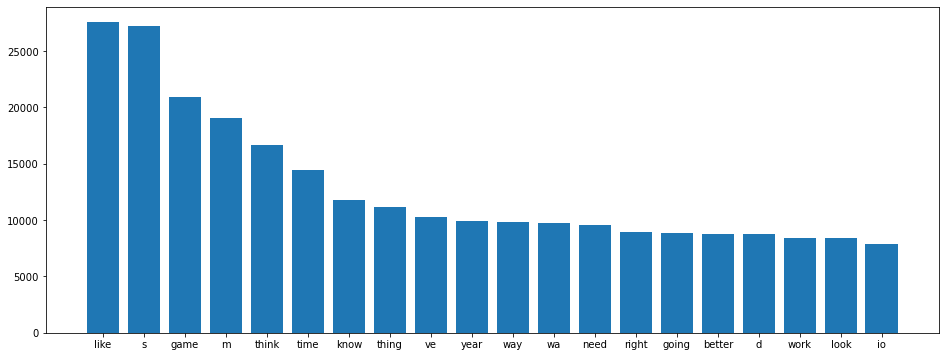

In [1284]:
plt.bar(words_df['words'][:20], words_df['count'][:20])

In [1168]:
# I wanna check the words with lowest frequency. I have checked the values from 1-5 to decided for min_df
words_df.loc[words_df['count'] == 5]

words  count
1           aa_x      5
17       ab_core      5
34       abdomen      5
36     abduction      5
37           abe      5
...          ...    ...
74684     watch      5
74685          👌      5
74691          😉      5
74693          😔      5
74696          😩      5

[14574 rows x 2 columns]

I have gone through several iteration of count vectorizer to find the result of min_df=1,2,3 and 0.1. I think min_df=4 seems just okay. Lets move ahead an dtry a few predictions

**TFIDF**

In [1169]:
# Re-establishing raing and testing data keeping all previous parameters for consistency
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1312, stratify=y)

In [1170]:
# Importing TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Running TF-IDF
tfidf = TfidfVectorizer(tokenizer=crazy_tokenizer.tokenize, min_df=5).fit(Xtrain)

# Transforming the data
Xtrain = cv.transform(Xtrain)
Xtest = cv.transform(Xtest)

In [1171]:
# Pickiling the tfidf model for safety
 
joblib.dump(tfidf, 'tfidf_reddit1.pkl')

['tfidf_reddit1.pkl']

#### Running a basic preliminary logistic regression for my Dataset as Baseline model 

Using Bag of Words and TFIDF vectorization

I will first run a simple **Logistic Regression** for my data set as a preliminary baseline model.




In [1172]:
X_train.shape

(185703, 74698)

In [1180]:
# Running a basic logistic regression
logreg_bag = LogisticRegression().fit(X_train, y_train)
logreg_tfidf = LogisticRegression().fit(Xtrain, ytrain)

print(f'Logistic Regression on bagofwords: {logreg_bag.score(X_train, y_train)}')
print(f'Logistic Regression on bagofwords: {logreg_bag.score(X_test, y_test)} \n')
print(f'Logistic Regression on tfidf: {logreg_tfidf.score(Xtrain, ytrain)}')
print(f'Logistic Regression on tfidf: {logreg_tfidf.score(Xtest, ytest)}')

Logistic Regression on bagofwords: 0.8399325805183546
Logistic Regression on bagofwords: 0.7326573435360046 

Logistic Regression on tfidf: 0.8288719083698163
Logistic Regression on tfidf: 0.7283475944563811


In [1175]:
# Saving logreg for bith vectorizing
joblib.dump(logreg_bag, 'logreg_bag')
joblib.dump(logreg_tfidf, 'logreg_tfidf')

['logreg_tfidf']

In [55]:
# To load data
# logreg = joblib.load(joblib_file)

In [1177]:
# getting the y_pred values to generate the calssification report and confusion matrix
y_pred_bag = logreg_bag.predict(X_test)
y_pred_tfidf = logreg_tfidf.predict(Xtest)

In [1298]:
logreg_bag.

(185703,)

In [1303]:
pd.DataFrame({'words': words, 'coeff': logreg_bag.coef_[0]}).argsort()

words     coeff
0                 aa  0.376181
1               aa_x -0.035774
2                aaa -0.494145
3           aaa_game -0.028937
4      aaa_publisher -0.008282
...              ...       ...
74693              😔  0.381535
74694              😛 -0.064150
74695              😢  0.716088
74696              😩  0.040429
74697              😭  0.463259

[74698 rows x 2 columns]

In [1294]:
(logreg_bag.coef_).shape

(5, 74698)

In [1178]:
np.unique(y_pred_bag, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 8637, 16841, 13577, 15739, 24793], dtype=int64))

In [1179]:
np.unique(y_pred_tfidf, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 8697, 16092, 13538, 15891, 25369], dtype=int64))

In [1182]:
report_initial_bag = classification_report(y_test, y_pred_bag)
print(report_initial_bag)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     10238
           1       0.69      0.69      0.69     16805
           2       0.80      0.72      0.76     15083
           3       0.75      0.71      0.73     16718
           4       0.70      0.83      0.76     20743

    accuracy                           0.73     79587
   macro avg       0.74      0.72      0.73     79587
weighted avg       0.74      0.73      0.73     79587



In [1183]:
report_initial_tfidf = classification_report(ytest, y_pred_tfidf)
print(report_initial_tfidf)

              precision    recall  f1-score   support

           0       0.78      0.67      0.72     10238
           1       0.70      0.67      0.68     16805
           2       0.79      0.71      0.75     15083
           3       0.74      0.71      0.73     16718
           4       0.68      0.84      0.75     20743

    accuracy                           0.73     79587
   macro avg       0.74      0.72      0.73     79587
weighted avg       0.73      0.73      0.73     79587



In [59]:
print(y_pred.shape)
print(y_test.shape)

(79592,)
(79592,)


In [60]:
columns_P = ['fitness_P', 'games_P', 'politics_P', 'science_technology_P', 'sports_P']
columns_T = ['fitness_T', 'games_T', 'politics_T', 'science_technology_T', 'sports_T']

cm = confusion_matrix(y_test, y_pred_bag)

pd.DataFrame(cm, columns=columns_P, index=columns_T)

fitness_P  games_P  politics_P  science_technology_P  \
fitness_T                  6901      894         275                   752   
games_T                     478    11708         610                  1314   
politics_T                  281     1042       10883                  1093   
science_technology_T        579     1677         987                 12030   
sports_T                    435     1794         666                   559   

                      sports_P  
fitness_T                 1421  
games_T                   2696  
politics_T                1784  
science_technology_T      1445  
sports_T                 17288

In [1184]:
columns_P = ['fitness_P', 'games_P', 'politics_P', 'science_technology_P', 'sports_P']
columns_T = ['fitness_T', 'games_T', 'politics_T', 'science_technology_T', 'sports_T']

cm = confusion_matrix(ytest, y_pred_tfidf)

pd.DataFrame(cm, columns=columns_P, index=columns_T)

fitness_P  games_P  politics_P  science_technology_P  \
fitness_T                  6813      747         314                   830   
games_T                     516    11229         676                  1425   
politics_T                  299      931       10758                  1168   
science_technology_T        611     1607        1068                 11825   
sports_T                    458     1578         722                   643   

                      sports_P  
fitness_T                 1534  
games_T                   2959  
politics_T                1927  
science_technology_T      1607  
sports_T                 17342

In [61]:
894+275+752+1421
3342 + 6901
435+1794+666+559

3454

I have used two vectorization techniques, CountVctorization and TFIDF. The result of CountVectorization is slightly better than TFIDF. Follwoing discussion will focus on the logreg nodel using CV.

The baseline logreg model using CountVectorization gives a testing score of ~84 % and training score of 73.26%. The classification report and confusion matrix are also seen above. To explain the results of this model, I will discuss the two extreme classes in my data: fitness with least training data and sports with maximum training data. 

**Fitness**
It has a precision of 79% and recall of 66%. Confusion matrix shows that of a total 10243 comments, 6901 comments in fitness were correctly predicted as fitness while 3342 were incorrectly predicted.

In an imbalanced classification problem with more than two classes, precision is calculated as the sum of true positives across all classes divided by the sum of true positives and false positives across all classes. (copied from https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)

**Sports**
It has a precision of 70% and recall of 83%. It has a lower precison than fiteness, meaning that there is a greater proportion of False positives for sports. However the recall is really good meaning that it a lower number of false negatives. SInce the dataset has most comments associated with sports, this result is not surprising. A lot more comments were falsely predicted as sports and a lot less sprots comments were miscalssifeid. It correctly identified 17288 sports and just 3454 incorrectly predicted.

In an imbalanced classification problem with more than two classes, recall is calculated as the sum of true positives across all classes divided by the sum of true positives and false negatives across all classes. (copied from https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)

---


#### Step 3 Part 2: Pipelines and Grid Search CV for ther three models

After that first I will run a basic logistic regression model on all the data followed by using **Pipeline and Grid Search CV** to optimize the following models:

1. Logistic Regression 
2. Decision Trees
3. KNN
4. SVM


**Logistic Regression**

The parameters to optimize are:
- c values
- scaler type
- penalty type (l2 or none)
- solver type
- dimension reduction

Since this problem is multi calss problem, 'liblinear' and l1 penalties cannot be used.

#### Using pipeline and grid search

I think I will do this in 2 steps:
1. Run each model seperately and find the best model parameters for each type
    - Logistic Regression
    - Random Forest
    - SVM
2. Find the best of the three identified earlier

In [1196]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pl = Pipeline([('scaler', StandardScaler()), ('dim_reducer', TruncatedSVD()), ('model', LogisticRegression())], memory=cachedir)

In [1197]:
# Re-establishing remainder and testing datasets keeping all previous parameters for consistency
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.3, random_state=1312, stratify=y)

In [1198]:
bagofwords = CountVectorizer(tokenizer=crazy_tokenizer.tokenize, min_df=5).fit(X_rem)

X_rem = bagofwords.transform(X_rem)
X_test = bagofwords.transform(X_test)

In [1356]:
joblib.dump(bagofwords, 'bagofwords_cv.pkl')

['bagofwords_cv.pkl']

In [1199]:
# Set a list of C values in a list
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

# this is a multicalss problem, therefore, l1 penality and solver=liblinear cannot be used
# Creating a logreg param grid
logreg_param_grid = [
         
    # using Dimensional Reduction
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'model': [LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1312, n_jobs=-1)],
     'model__C': c_values,
     'dim_reducer': [TruncatedSVD()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'dim_reducer__n_iter': [5, 7, 10]},
   
    # not using Dimensional Reduction
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'model': [LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1312, n_jobs=-1)],
     'model__C': c_values,
     'dim_reducer': [None]}
]

# Just to be explicit I am giving a multi_class='multinomial' parameter, because for a multiclass problem, 
# the by deafault option is to multinomial

In [1200]:
%%time
# Instantiate logreg grid search
logreg_gs = GridSearchCV(my_pl, param_grid=logreg_param_grid, n_jobs=-1, verbose=5, cv=5)

# Fit the log-reg grid search
logreg_gs_fit = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 572 candidates, totalling 2860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2860 out of 2860 | elapsed: 12.9min finished


Wall time: 13min 23s


In [1201]:
# Getting the best model
logreg_gs_fit.best_estimator_

Pipeline(memory='C:\\Users\\madih\\AppData\\Local\\Temp\\tmpy72cufsb',
         steps=[('scaler', None), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=1, multi_class='multinomial', n_jobs=-1,
                                    random_state=1312))])

In [1202]:
# Getting the accuracies
print(f'Remiander accuracy is: {logreg_gs_fit.score(X_rem, y_rem)}')
print(f'Testing accuracy is: {logreg_gs_fit.score(X_test, y_test)}')

Remiander accuracy is: 0.8399325805183546
Testing accuracy is: 0.7326573435360046


In [1203]:
# getting predicted y for confusion matrix and classification report
y_pred_logreg_gs = logreg_gs_fit.predict(X_test)
y_pred_logreg_gs

array([1, 3, 4, ..., 1, 4, 0], dtype=int64)

In [1204]:
logreg_gs_fit.predict_proba(X_test)
logreg_gs_fit.predict_log_proba(X_test)

array([[-6.82266938e+00, -2.88313242e-02, -7.06374343e+00,
        -4.44134239e+00, -4.22023620e+00],
       [-5.64646952e+00, -6.07616860e+00, -5.74288079e+00,
        -1.08153624e-02, -6.36273200e+00],
       [-3.37328072e+00, -1.11972421e+00, -1.46650014e+00,
        -2.62644249e+00, -1.08979250e+00],
       ...,
       [-9.74268079e+00, -3.67149802e-04, -1.18359051e+01,
        -1.01169916e+01, -8.25201680e+00],
       [-8.36623504e+00, -6.83006035e+00, -9.53549024e+00,
        -7.90564681e+00, -1.75582087e-03],
       [-9.00091127e-05, -1.03563014e+01, -1.13465730e+01,
        -9.99934340e+00, -1.38422702e+01]])

In [1369]:
np.log(logreg_gs_fit.predict_proba(X_test)*10000)

array([[ 2.38767099,  9.18150905,  2.14659695,  4.76899798,  4.99010417],
       [ 3.56387085,  3.13417177,  3.46745958,  9.19952501,  2.84760838],
       [ 5.83705966,  8.09061616,  7.74384023,  6.58389788,  8.12054788],
       ...,
       [-0.53234042,  9.20997322, -2.62556472, -0.90665125,  0.95832357],
       [ 0.84410533,  2.38028002, -0.32514987,  1.30469356,  9.20858455],
       [ 9.21025036, -1.14596101, -2.13623261, -0.78900303, -4.63192984]])

In [1205]:
# Getting the classification report
class_report = classification_report(y_test, y_pred_logreg_gs)
print(class_report)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     10238
           1       0.69      0.69      0.69     16805
           2       0.80      0.72      0.76     15083
           3       0.75      0.71      0.73     16718
           4       0.70      0.83      0.76     20743

    accuracy                           0.73     79587
   macro avg       0.74      0.72      0.73     79587
weighted avg       0.74      0.73      0.73     79587



In [1206]:
# Creating a confusion matrix
columns_P = ['fitness_P', 'games_P', 'politics_P', 'science_technology_P', 'sports_P']
columns_T = ['fitness_T', 'games_T', 'politics_T', 'science_technology_T', 'sports_T']

cm = confusion_matrix(y_test, y_pred_logreg_gs)

pd.DataFrame(cm, columns=columns_P, index=columns_T)

fitness_P  games_P  politics_P  science_technology_P  \
fitness_T                  6800      839         294                   825   
games_T                     513    11537         639                  1361   
politics_T                  289     1011       10882                  1113   
science_technology_T        596     1744        1071                 11814   
sports_T                    439     1710         691                   626   

                      sports_P  
fitness_T                 1480  
games_T                   2755  
politics_T                1788  
science_technology_T      1493  
sports_T                 17277

In [1355]:
joblib.dump(logreg_gs_fit.best_estimator_, 'pickled_best_logreg.pkl')

['pickled_best_logreg.pkl']

**Decison Trees Models**

The parameters to optimize are:
- max_depth
- criterion

Decision Trees do not need scaled data, therefore, i will give it scaler = None


In [121]:
# list of max depth to iterate over
max_depth = list(range(500, 1600, 100))

# Creating a decision tree params grid
dtrees_params_grid = [
    
    # Using dimensional reduction
    {'scaler': [None],
     'model':[DecisionTreeClassifier(random_state=1312)],
     'model__max_depth': max_depth,
     'dim_reducer': [TruncatedSVD()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'dim_reducer__n_iter': [5, 7, 10]
     },
    
    # Not using dimensional reduction
    {'scaler': [None],
     'model': [DecisionTreeClassifier(random_state=1312)],
     'model__max_depth': max_depth,
     'dim_reducer': [None]}
]

In [122]:
max_depth

[500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]

In [123]:
%%time
# Instantiating a Decision Tree gridsearch
dtree_gs = GridSearchCV(my_pl, param_grid=dtrees_params_grid, n_jobs=-1, cv=5, verbose=5)

# Fit the log-reg grid search
dtrees_gs_fit = dtree_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 143 candidates, totalling 715 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 715 out of 715 | elapsed: 137.3min finished


Wall time: 2h 27min 58s


In [124]:
# getting the parameters of the best decision tree model
dtrees_gs_fit.best_estimator_

Pipeline(memory='C:\\Users\\madih\\AppData\\Local\\Temp\\tmpczrug0od',
         steps=[('scaler', None), ('dim_reducer', None),
                ('model',
                 DecisionTreeClassifier(max_depth=1400, random_state=1312))])

In [125]:
# print accuracy
print(f'Decision Tree training accuracy: {dtrees_gs_fit.score(X_rem, y_rem)}')
print(f'Decision Tree testing accuracy: {dtrees_gs_fit.score(X_test, y_test)}')

Decision Tree training accuracy: 0.9157687274842087
Decision Tree testing accuracy: 0.5933381079824595


In [126]:
# getting the predicted values for confusion matirx and classification report
y_pred_dt = dtrees_gs_fit.predict(X_test)

In [309]:
# classification report
class_report = classification_report(y_test, y_pred_dt)
print(class_report)

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     10238
           1       0.57      0.48      0.52     16805
           2       0.69      0.58      0.63     15083
           3       0.61      0.56      0.58     16718
           4       0.55      0.75      0.63     20743

    accuracy                           0.59     79587
   macro avg       0.61      0.58      0.59     79587
weighted avg       0.60      0.59      0.59     79587



In [130]:
# confusion matirx

# Creating a confusion matrix
columns_P = ['fitness_P', 'games_P', 'politics_P', 'science_technology_P', 'sports_P']
columns_T = ['fitness_T', 'games_T', 'politics_T', 'science_technology_T', 'sports_T']

cm = confusion_matrix(y_test, y_pred_dt)

pd.DataFrame(cm, columns=columns_P, index=columns_T)

fitness_P  games_P  politics_P  science_technology_P  \
fitness_T                  5447      869         492                  1202   
games_T                     849     8094         988                  1942   
politics_T                  611     1207        8822                  1657   
science_technology_T       1113     1937        1515                  9281   
sports_T                    892     2083        1035                  1155   

                      sports_P  
fitness_T                 2228  
games_T                   4932  
politics_T                2786  
science_technology_T      2872  
sports_T                 15578

### Twitter Data 

Cleaning Twitter data.

There are two functions in this section of the notebook:
1. load_jsol() - This function has been taken from a medium post I found to open and  load jsol files

2. load_and_score, I have created to clean the tweets, and run predictions on it. 

In [1410]:
# Importing Jason, and opening up the JSON files in python.

import glob
import os
import json

# I found this code from:
# https://medium.com/@galea/how-to-love-jsonl-using-json-line-format-in-your-workflow-b6884f65175b

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [1465]:
def load_and_score(file_names_list) -> list:
    ''' 
    Input: List of files name to load, clean and score.
    
    This funstion will take in a list of jsonl files and for each file, load, clean, seperate text, 
    tokenize, vectorize, run logistic regression on them, provide predictions, genrate world clouds 
    and bar charts.    
    
    Output: lists of Score and score_probabilities 
    '''
    
    
    score = []
    score_prob = []
    length = range(len(file_names_list))
    print(length)
    
    
    for i in length:
        
        print('\n', i)
        # Using the previous defined function to load the files
        load = load_jsonl(file_names_list[i])
        
        # Converting the loaded jsonl into a pandas dataframe
        df = pd.DataFrame(load)
                
        # Seperating the text from the df and concatinating it together
        text = df['text'].str.cat(sep=' ')
               
        # Converting the text into a series
        text = pd.Series(text)
               
        # Vectorizing the text - it will be tokenized also during the transformation 
        text = bagofwords.transform(text)
        print(f'Transformed text shape: {text.shape}, \n')
        
        # Running the finalized logistic regression on the text to get predicted values, and probablities of predictions
        pred = logreg_gs_fit.predict(text)
        pred_prob = logreg_gs_fit.predict_proba(text)
                
        # reinstantiating the text into str and concatinating it for word cloud generating
        text = df['text'].str.cat(sep=' ')
        
        # tokenizing the text and joing the tokens in one str
        tokens=crazy_tokenizer.tokenize(text)
        tokens = ', '.join(tokens)
        
        # generating a word cloud
        wordcloud = WordCloud(max_font_size=50, background_color='white', colormap='Dark2').generate(tokens)
        
        
        print(f'Plotting WordClouds and Bar chart for: {file_names_list[i]}')
        # plotting the word cloud and bar plot for each user
        plt.subplots(1,2, figsize=(15, 4))

        plt.subplot(1,2,1)
        plt.title(file_names_list[i], fontweight='bold')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')


        # bar subplot
        x=['fitness', 'games', 'politics', 'science_technology', 'sports']
        plt.subplot(1,2,2)
        plt.bar(x, pred_prob[0], color='orange', zorder=2)
        plt.yscale('log')
        plt.title('Areas of Potential Careers Interest')
        plt.xlabel('Classes', fontweight='bold')
        plt.ylabel('Frequency of Classes', fontweight='bold')
        plt.grid(b=True, color='grey', alpha=0.2, zorder=0)


        plt.tight_layout()
        plt.show()
        
        score.append({file_names_list[i]: pred})
        score_prob.append({file_names_list[i]: pred_prob})
        print(f'Career Prediction:{pred} \n')
        print(f'Career Predictions Probability: {pred_prob}')
        
    return score, score_prob

range(0, 1)

 0
Loaded 792 records from C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl


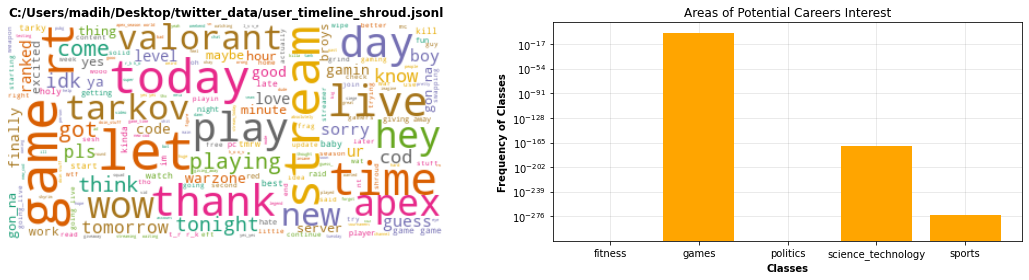

Career Prediction:[1] 

Career Predictions Probability: [[1.57704423e-313 1.00000000e+000 0.00000000e+000 3.50403261e-171
  4.19035896e-274]]


In [1466]:
twitter_list = ['C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl']
hh, jj = load_and_score(twitter_list)

In [1469]:
twitter_list = ['C:/Users/madih/Desktop/twitter_data/user_timeline_TigerWoods.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_Cristiano_.jsonl',\
                'C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_sundarpichai.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_realDonaldTrump.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_ProfBrianCox.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_JustinTrudeau_.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_balletbeautiful.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_harleypasternak.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_Ninja.jsonl',\
                'C:/Users/madih/Desktop/twitter_data/user_timeline_BarackObama.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_DendiBoss.jsonl',\
                'C:/Users/madih/Desktop/twitter_data/user_timeline_elonmusk.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_Gunnar.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_KingJames.jsonl', 
                'C:/Users/madih/Desktop/twitter_data/user_timeline_neiltyson.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_rogerfederer.jsonl', \
                'C:/Users/madih/Desktop/twitter_data/user_timeline_serenawilliams.jsonl']

range(0, 18)

 0
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_TigerWoods.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_TigerWoods.jsonl


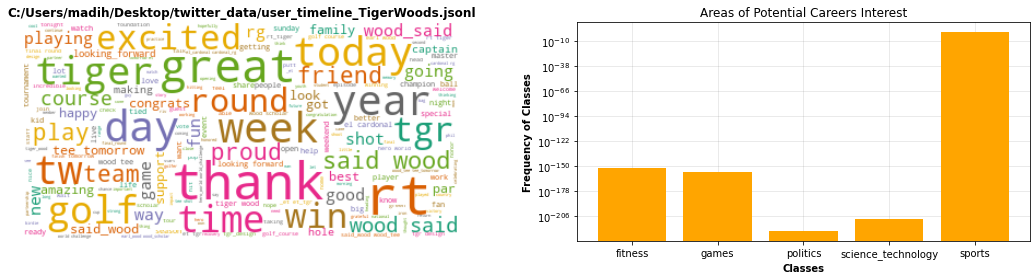

Career Prediction:[4] 

Career Predictions Probability: [[2.71897052e-152 7.96712882e-158 1.89967222e-223 5.10658904e-210
  1.00000000e+000]]

 1
Loaded 3153 records from C:/Users/madih/Desktop/twitter_data/user_timeline_Cristiano_.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_Cristiano_.jsonl


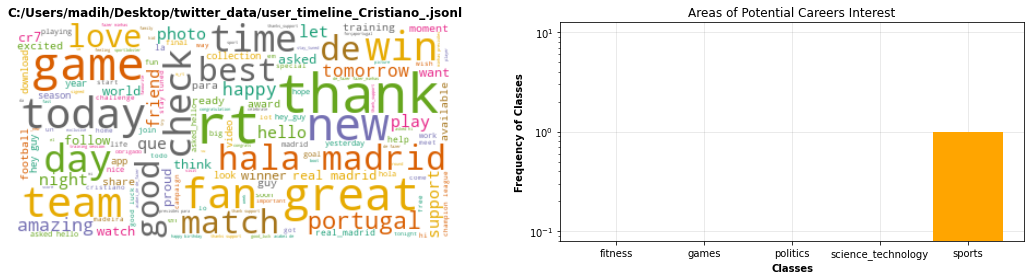

Career Prediction:[4] 

Career Predictions Probability: [[0. 0. 0. 0. 1.]]

 2
Loaded 792 records from C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl


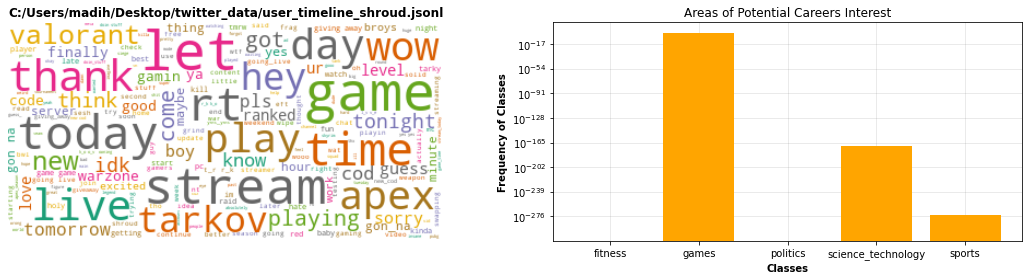

Career Prediction:[1] 

Career Predictions Probability: [[1.57704423e-313 1.00000000e+000 0.00000000e+000 3.50403261e-171
  4.19035896e-274]]

 3
Loaded 799 records from C:/Users/madih/Desktop/twitter_data/user_timeline_sundarpichai.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_sundarpichai.jsonl


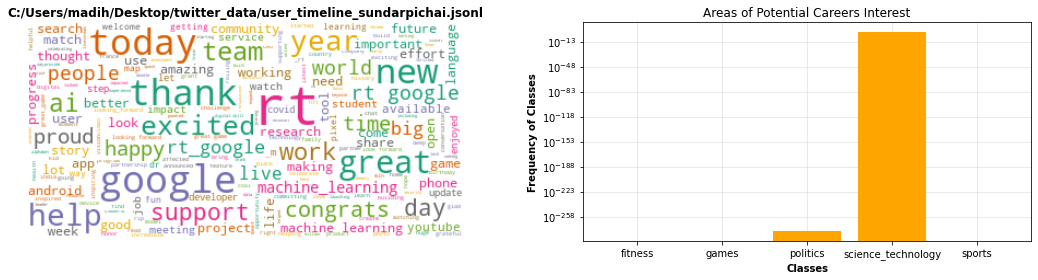

Career Prediction:[3] 

Career Predictions Probability: [[0.0000000e+000 0.0000000e+000 6.6277001e-279 1.0000000e+000
  0.0000000e+000]]

 4
Loaded 240 records from C:/Users/madih/Desktop/twitter_data/user_timeline_realDonaldTrump.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_realDonaldTrump.jsonl


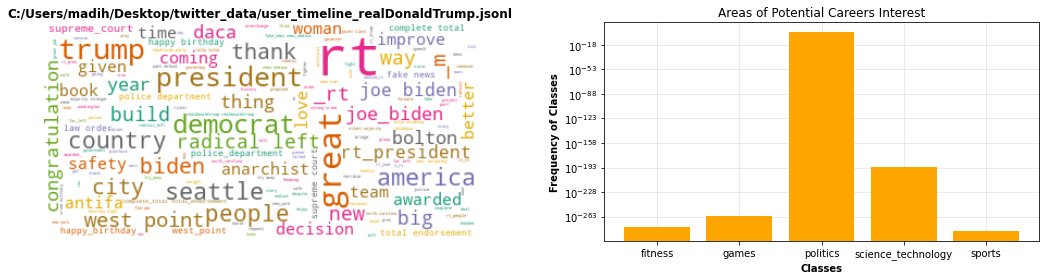

Career Prediction:[2] 

Career Predictions Probability: [[2.42220635e-279 1.27257602e-263 1.00000000e+000 6.00430992e-193
  2.47276422e-284]]

 5
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_ProfBrianCox.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_ProfBrianCox.jsonl


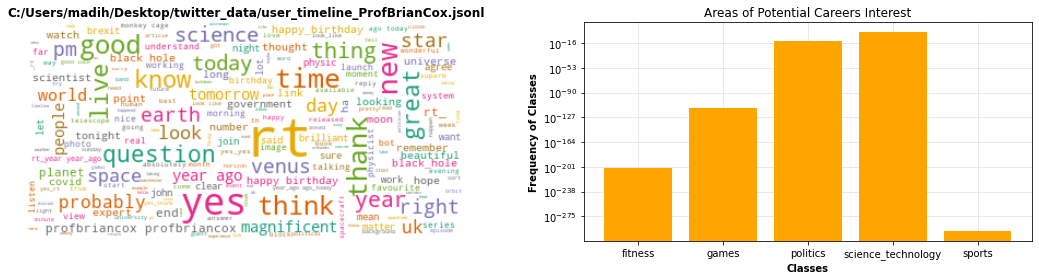

Career Prediction:[3] 

Career Predictions Probability: [[1.16296241e-203 1.24687844e-113 1.33594175e-013 1.00000000e+000
  1.99622782e-297]]

 6
Loaded 3200 records from C:/Users/madih/Desktop/twitter_data/user_timeline_JustinTrudeau_.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_JustinTrudeau_.jsonl


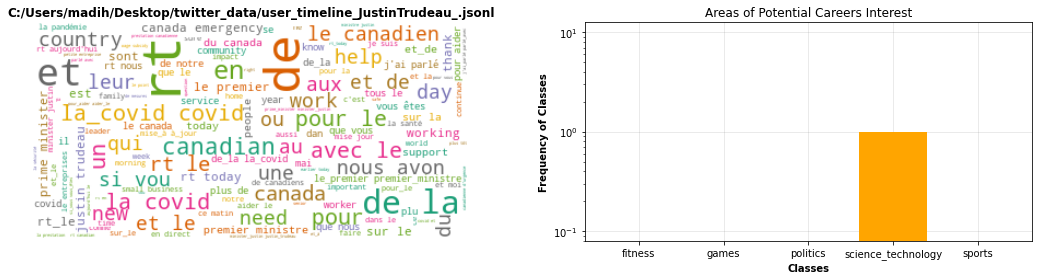

Career Prediction:[3] 

Career Predictions Probability: [[0. 0. 0. 1. 0.]]

 7
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_balletbeautiful.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_balletbeautiful.jsonl


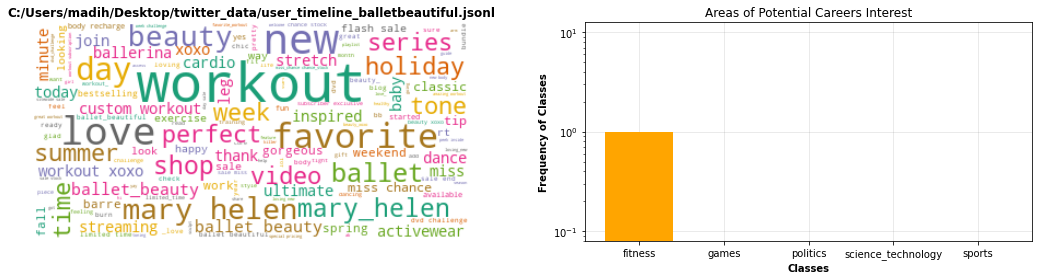

Career Prediction:[0] 

Career Predictions Probability: [[1. 0. 0. 0. 0.]]

 8
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_harleypasternak.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_harleypasternak.jsonl


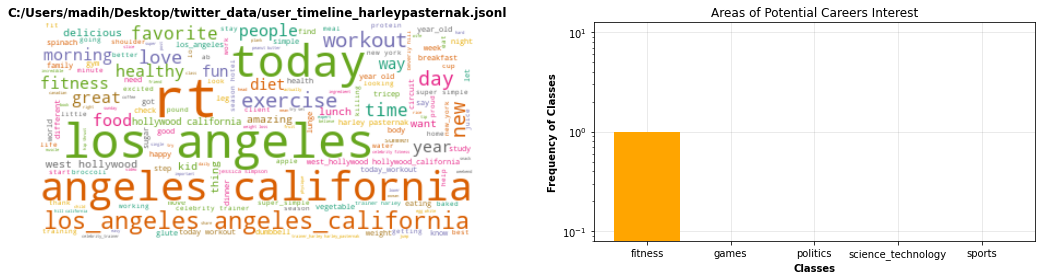

Career Prediction:[0] 

Career Predictions Probability: [[1. 0. 0. 0. 0.]]

 9
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_Ninja.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_Ninja.jsonl


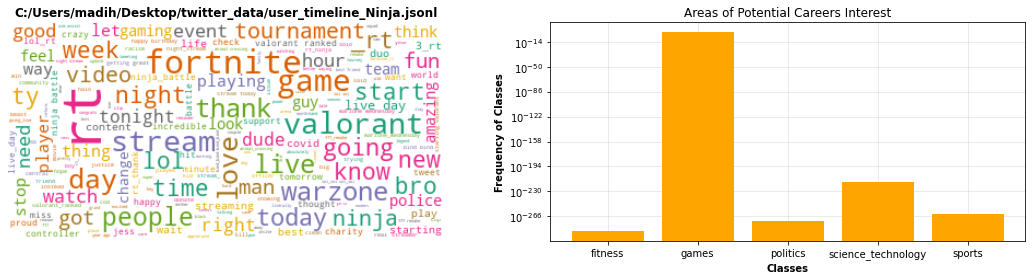

Career Prediction:[1] 

Career Predictions Probability: [[3.97727795e-288 1.00000000e+000 9.79748554e-274 1.19825157e-217
  4.70842618e-264]]

 10
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_BarackObama.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_BarackObama.jsonl


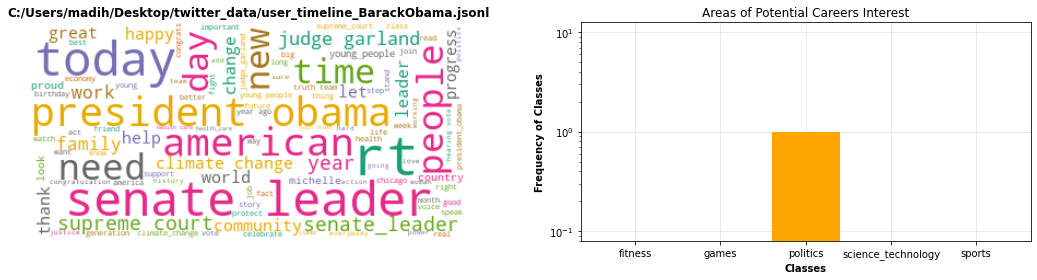

Career Prediction:[2] 

Career Predictions Probability: [[0. 0. 1. 0. 0.]]

 11
Loaded 799 records from C:/Users/madih/Desktop/twitter_data/user_timeline_DendiBoss.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_DendiBoss.jsonl


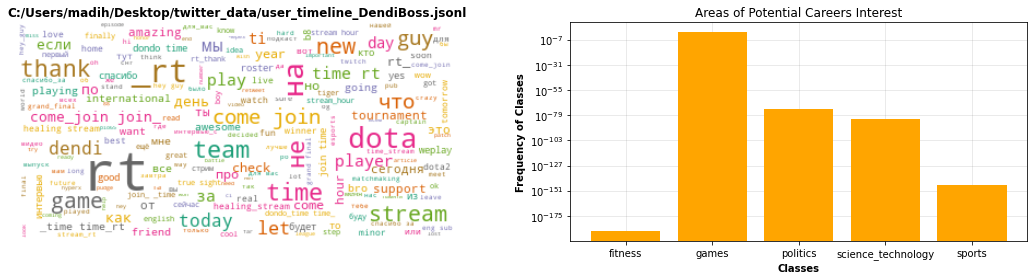

Career Prediction:[1] 

Career Predictions Probability: [[3.93196744e-190 1.00000000e+000 8.75004375e-074 1.16333463e-083
  3.65073573e-146]]

 12
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_elonmusk.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_elonmusk.jsonl


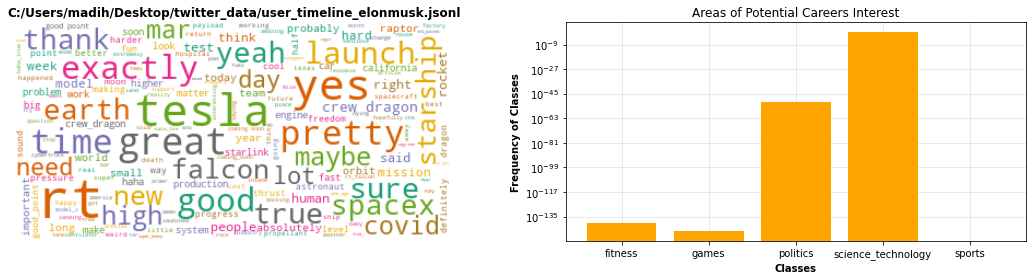

Career Prediction:[3] 

Career Predictions Probability: [[1.21559775e-140 2.67863272e-146 9.99323361e-052 1.00000000e+000
  0.00000000e+000]]

 13
Loaded 799 records from C:/Users/madih/Desktop/twitter_data/user_timeline_Gunnar.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_Gunnar.jsonl


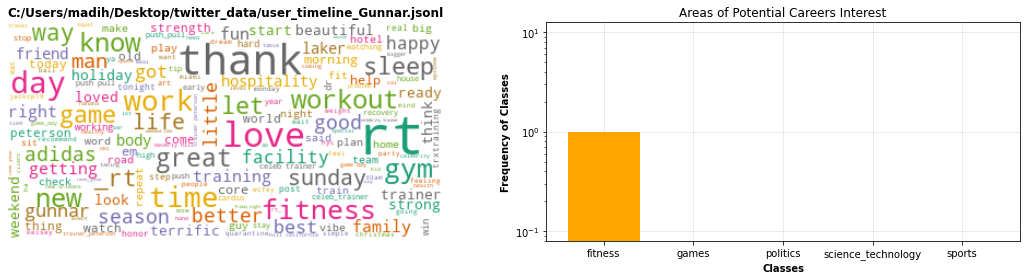

Career Prediction:[0] 

Career Predictions Probability: [[1. 0. 0. 0. 0.]]

 14
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_KingJames.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_KingJames.jsonl


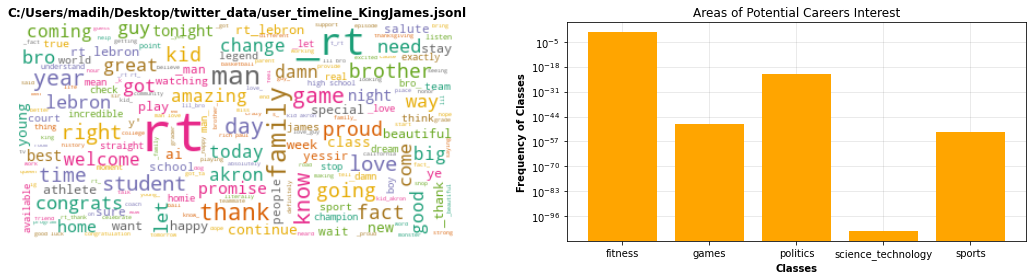

Career Prediction:[0] 

Career Predictions Probability: [[1.00000000e+000 7.78020341e-049 2.29877647e-022 1.72419475e-104
  1.22453772e-052]]

 15
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_neiltyson.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_neiltyson.jsonl


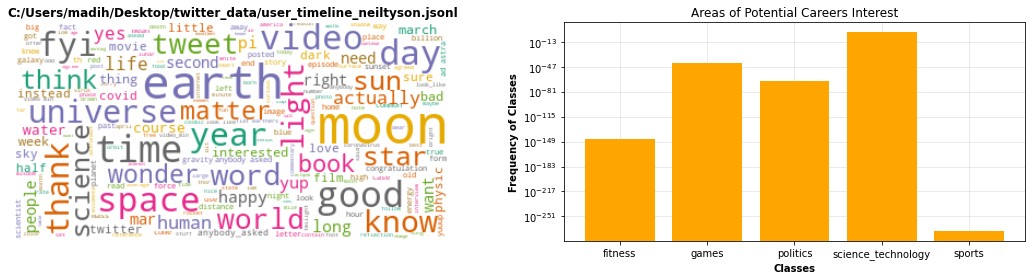

Career Prediction:[3] 

Career Predictions Probability: [[1.94035414e-146 4.55803710e-042 1.98948392e-067 1.00000000e+000
  1.54120633e-271]]

 16
Loaded 797 records from C:/Users/madih/Desktop/twitter_data/user_timeline_rogerfederer.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_rogerfederer.jsonl


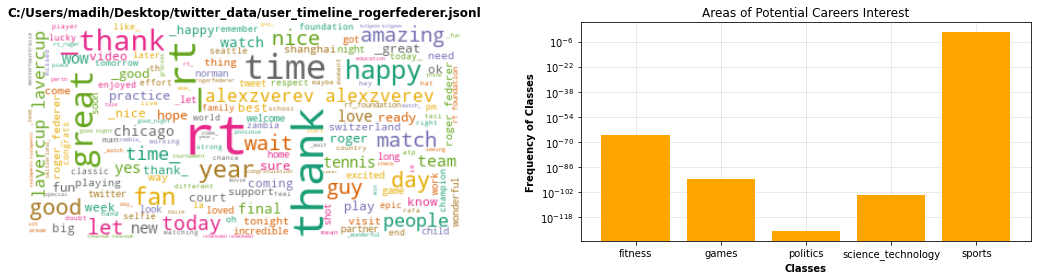

Career Prediction:[4] 

Career Predictions Probability: [[2.90094501e-066 3.91554481e-094 1.28597618e-127 8.80409111e-105
  1.00000000e+000]]

 17
Loaded 800 records from C:/Users/madih/Desktop/twitter_data/user_timeline_serenawilliams.jsonl
Transformed text shape: (1, 74698), 

Plotting WordClouds and Bar chart for: C:/Users/madih/Desktop/twitter_data/user_timeline_serenawilliams.jsonl


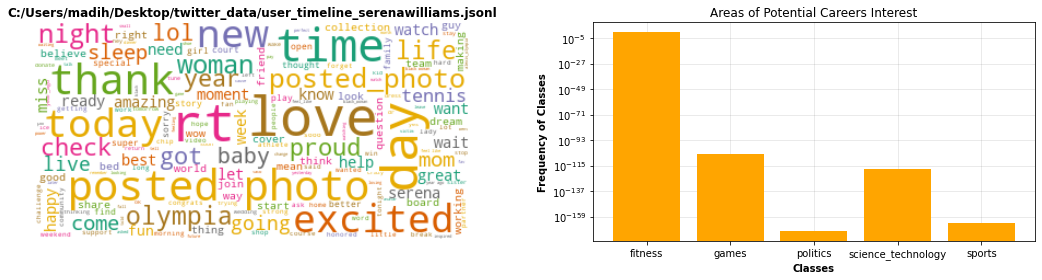

Career Prediction:[0] 

Career Predictions Probability: [[1.00000000e+000 6.57283976e-106 3.55066932e-172 7.08935256e-119
  6.55784339e-165]]
Wall time: 14min 8s


In [1471]:
%%time
predictions, predictions_probab = load_and_score(twitter_list)

In [1474]:
predictions

[{'C:/Users/madih/Desktop/twitter_data/user_timeline_TigerWoods.jsonl': array([4], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_Cristiano_.jsonl': array([4], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl': array([1], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_sundarpichai.jsonl': array([3], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_realDonaldTrump.jsonl': array([2], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_ProfBrianCox.jsonl': array([3], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_JustinTrudeau_.jsonl': array([3], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_balletbeautiful.jsonl': array([0], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_harleypasternak.jsonl': array([0], dtype=int64)},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_Ninja.jsonl': array([1], dtype=int64)},
 {'C:/

In [1473]:
predictions_probab

[{'C:/Users/madih/Desktop/twitter_data/user_timeline_TigerWoods.jsonl': array([[2.71897052e-152, 7.96712882e-158, 1.89967222e-223,
          5.10658904e-210, 1.00000000e+000]])},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_Cristiano_.jsonl': array([[0., 0., 0., 0., 1.]])},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_shroud.jsonl': array([[1.57704423e-313, 1.00000000e+000, 0.00000000e+000,
          3.50403261e-171, 4.19035896e-274]])},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_sundarpichai.jsonl': array([[0.0000000e+000, 0.0000000e+000, 6.6277001e-279, 1.0000000e+000,
          0.0000000e+000]])},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_realDonaldTrump.jsonl': array([[2.42220635e-279, 1.27257602e-263, 1.00000000e+000,
          6.00430992e-193, 2.47276422e-284]])},
 {'C:/Users/madih/Desktop/twitter_data/user_timeline_ProfBrianCox.jsonl': array([[1.16296241e-203, 1.24687844e-113, 1.33594175e-013,
          1.00000000e+000, 1.99622782e-297]])},
 

In [1496]:
# creating a dataframe for better visualization
celeb_pred = pd.DataFrame({'Celebrity': ['Tiger Woods', 'Ronaldo', 'Shroud', 'Sundar Pichai', 'Donald Trump', 'Prof Brain Cox', 'Justin Trudeau', 'Ballet Beautiful',
                                         'Harley Pasternak', 'Ninja', 'Barak Obama', 'Dendi Boss', 'Elon Musk', 'Gunnar', 'Le Bron James', 'Roger Federer', 'Serena Williams'], 
                           'Profession': ['Sports', 'Sports', 'Games', 'ScienceTechnology', 'Politics', 'ScienceTechnology', 'Politics', 'Fitness', 
                                          'Fitness', 'Games', 'Politics', 'Games', 'ScienceTechnology', 'Fitness', 'Sports', 'Sports', 'Sports'],
                           'Prediction': ['Sports', 'Sports', 'Games', 'ScienceTechnology', 'Politics', 'ScienceTechnology', 'ScienceTechnology', 'Fitness', 
                                          'Fitness', 'Games', 'Politics', 'Games', 'ScienceTechnology', 'Fitness', 'Fitness', 'Sports', "Fitness"],
                           'Description': ['Golf Player', 'Soccer Player', 'Famous Gamer', 'CEO Google', 'Politician', 'Physicist', 'Politicain', 
                                           'Celebrity Trainer', 'Celebrity Trainer', 'Famous Gamer', 'Politician', 'Famous Gamer', 
                                           'Co-founded and leads Tesla, SpaceX, Neuralink and The Boring Company', 'Celebrity Trainer', 'Basketball Player',
                                          'Tennis Player', 'Tennis pLayer']
                          })

In [1497]:
celeb_pred

Celebrity         Profession         Prediction  \
0        Tiger Woods             Sports             Sports   
1            Ronaldo             Sports             Sports   
2             Shroud              Games              Games   
3      Sundar Pichai  ScienceTechnology  ScienceTechnology   
4       Donald Trump           Politics           Politics   
5     Prof Brain Cox  ScienceTechnology  ScienceTechnology   
6     Justin Trudeau           Politics  ScienceTechnology   
7   Ballet Beautiful            Fitness            Fitness   
8   Harley Pasternak            Fitness            Fitness   
9              Ninja              Games              Games   
10       Barak Obama           Politics           Politics   
11        Dendi Boss              Games              Games   
12         Elon Musk  ScienceTechnology  ScienceTechnology   
13            Gunnar            Fitness            Fitness   
14     Le Bron James             Sports            Fitness   
15     Roger Federer             Sports             Sports   
16   Serena Williams             Sports            Fitness   

                                          Description  
0                                         Golf Player  
1                                       Soccer Player  
2                                        Famous Gamer  
3                                          CEO Google  
4                                          Politician  
5                                           Physicist  
6                                          Politicain  
7                                   Celebrity Trainer  
8                                   Celebrity Trainer  
9                                        Famous Gamer  
10                                         Politician  
11                                       Famous Gamer  
12  Co-founded and leads Tesla, SpaceX, Neuralink ...  
13                                  Celebrity Trainer  
14                                  Basketball Player  
15                                      Tennis Player  
16                                      Tennis pLayer

In [1498]:
# the code to highligh was taken from the follwoing link:
# https://kanoki.org/2019/01/02/pandas-trick-for-the-day-color-code-columns-rows-cells-of-dataframe/

def highlight_rows(df):
    if df.Profession != df.Prediction:
        return ['background-color: pink']*4
    else:
        return ['background-color: white']*4
        
celeb_pred.style.apply(highlight_rows, axis=1)

Three things have happened above:

1. Model transferability was checka nd established by using the model on 17 famous twitter profiles
2. Words clouds and bar plots showing the relative contibution of conversation associated with each of the 5 career buckets was generated and visualized
3. The respective prediction and prediction_probablities were found using the finalized logistic regression model
4. The model predicted 14 of the celebraties correctly while 3 were not, showing a 83% accuracy
5. 